# Using Transition Matrix Methods and Jacobians with ConsMarkovModel

By Kenneth Eva (kjeeva@sas.upenn.edu) and William Du (wdu9@jhu.edu)

This Jupyter Notebook demonstrates how to non-stochastically simulate an economy with transition matrices and compute Jacobians for the ConsMarkovModel.

For this notebook, we're using MarkovConsumerTypes that are modified with transition matrix methods. In HAFiscal, the AggFiscalType is an extension of the Markov consumer. So, these exercises can be repeated using the AggFiscalType with some modifications. It is important to note:
- We've turned off permanent income growth
- There is no splurging in these simulations
- We're not tracking permamnent income, but instead using the Harmenburg trick

## Set Up

### Import Packages

In [1]:
import os
os.chdir(os.path.expanduser("~"))
os.chdir('./HAFiscal-Latest/Code/HA-Models/FromPandemicCode')

import numpy as np
from ConsMarkovModel import MarkovConsumerType
from copy import deepcopy
from Parameters import returnParameters
import scipy.sparse as sp
import matplotlib.pyplot as plt

### Declare Dictionaries

Here we're importing the parametrizations for each education type in HAFiscal. 

For the remainder of the notebook, all demonstrations will be with a high school graduate type with a discount factor set to the midpoint of its $\beta$ distribution.

In [2]:
# Importing parametrizations from HAFiscal
[init_dropout, init_highschool, init_college, init_ADEconomy, DiscFacDstns,\
DiscFacCount, AgentCountTotal, base_dict, num_max_iterations_solvingAD,\
convergence_tol_solvingAD, UBspell_normal, num_base_MrkvStates, \
data_EducShares, max_recession_duration, num_experiment_periods,\
recession_changes, UI_changes, recession_UI_changes,\
TaxCut_changes, recession_TaxCut_changes, Check_changes, recession_Check_changes] = \
    returnParameters(Parametrization='Baseline',OutputFor='_Main.py')

# Adding mGrid parameters for transition matrices and switching off permanent growth
init_dropout["mCount"] = 200
init_dropout["mFac"] = 3
init_dropout["mMin"] = 1e-4
init_dropout["mMax"] = 10000
init_dropout["PermGroFac"] = [[1.0, 1.0, 1.0, 1.0]] 
init_dropout["pLvlInitMean"] = 0
init_dropout["pLvlInitStd"] = 0
init_dropout["DiscFac"] = 0.735
init_highschool["mCount"] = 200
init_highschool["mFac"] = 3
init_highschool["mMin"] = 1e-4
init_highschool["mMax"] = 10000
init_highschool["pLvlInitMean"] = 0
init_highschool["pLvlInitStd"] = 0
init_highschool["PermGroFac"] = [[1.0, 1.0, 1.0, 1.0]] 
init_highschool["DiscFac"] = 0.9234
init_college["mCount"] = 200
init_college["mFac"] = 3
init_college["mMin"] = 1e-4
init_college["mMax"] = 10000
init_college["PermGroFac"] = [[1.0, 1.0, 1.0, 1.0]] 
init_college["pLvlInitMean"] = 0
init_college["pLvlInitStd"] = 0
init_college["DiscFac"] = 0.9838


CRRA =  2.0
Rfree_base =  [1.01]
Rspell =  6
Splurge =  0.24904508521012406
beta/nablas =  [[0.734957225906162, 0.2983675991190151, 6.387042414747095, 0.9983196013580541], [0.9233503915004295, 0.13152852940397675, 4.116510342530347, 0.9839601688607849], [0.9838288205923613, 0.009618457146131559, 7.031814336738526, 0.9991174519071605]]
TaxCutAdjFactor =  1
CheckAdjFactor =  1
IncUnempNoBenefits =  0.5
IncUnemp =  0.7
ADelasticity =  0.3
EducationGroup:  0 , betaDistr : [0.4792, 0.5645, 0.6497, 0.735, 0.8202, 0.9055, 0.9907]
EducationGroup:  1 , betaDistr : [0.8106, 0.8482, 0.8858, 0.9234, 0.9609, 0.9892, 0.9892]
EducationGroup:  2 , betaDistr : [0.9756, 0.9783, 0.9811, 0.9838, 0.9866, 0.9893, 0.9921]


/Users/kennetheva/HAFiscal-Latest/Code/HA-Models/FromPandemicCode/EstimParameters.py:207: ComplexWarning: Casting complex values to real discards the imaginary part
  init_mrkv_dist_c = vecs_c[:,idx_c].astype(float)/np.sum(vecs_c[:,idx_c].astype(float))


### Create Instances of Agents and Income Shock Distributions

We now declare an instance of each education type and generate the income shock distributions for all Markov states.

In [3]:
# Creating instances of each education type in the HAFiscal paper
agent_DO = MarkovConsumerType(**init_dropout)
agent_DO.cycles = 0
agent_HS = MarkovConsumerType(**init_highschool)
agent_HS.cycles = 0
agent_CG = MarkovConsumerType(**init_college)
agent_CG.cycles = 0
AggDemandEconomy = MarkovConsumerType(**init_ADEconomy)
BaseTypeList = [agent_DO, agent_HS, agent_CG]
          
# Setting parameters for the Jacobian exercises
bigT = 100
dx = 0.0001

# Creating income shock distributions for all Markov states, as in HAFiscal
IncShkDstn = []
IncShkDstn_dx = []

# HAF distributions: employed, unemployed with benefits for 2 periods,
# unemployed with benefits for 1 period, unemployed with no benefits
for ThisType in BaseTypeList:
    IncShkDstn_emp = deepcopy(ThisType.IncShkDstn[0])
    IncShkDstn_emp_dx = deepcopy(IncShkDstn_emp)
    IncShkDstn_emp_dx.atoms[1] = IncShkDstn_emp_dx.atoms[1] * (1 + dx)    

    # quasi HAF unemp
    IncShkDstn_unemp = deepcopy(IncShkDstn_emp)
    IncShkDstn_unemp.atoms[0] = IncShkDstn_unemp.atoms[0] * 0 + 1.0
    IncShkDstn_unemp.atoms[1] = IncShkDstn_unemp.atoms[1] * 0 + 0.7
    IncShkDstn_unemp_dx = deepcopy(IncShkDstn_unemp)
    IncShkDstn_unemp_dx.atoms[1] = IncShkDstn_unemp_dx.atoms[1] * (1 + dx)    

    # HAF unemp
    IncShkDstn_unemp2 = deepcopy(IncShkDstn_emp)
    IncShkDstn_unemp2.atoms[0] = IncShkDstn_unemp2.atoms[0] * 0 + 1.0
    IncShkDstn_unemp2.atoms[1] = IncShkDstn_unemp2.atoms[1] * 0 + 0.7
    IncShkDstn_unemp2_dx = deepcopy(IncShkDstn_unemp2)
    IncShkDstn_unemp2_dx.atoms[1] = IncShkDstn_unemp2_dx.atoms[1] * (1 + dx) 

    IncShkDstn_unemp_nb = deepcopy(IncShkDstn_emp)
    IncShkDstn_unemp_nb.atoms[0] = IncShkDstn_unemp.atoms[0] * 0 + 1.0
    IncShkDstn_unemp_nb.atoms[1] = IncShkDstn_unemp.atoms[1] * 0 + 0.5
    IncShkDstn_unemp_nb_dx = deepcopy(IncShkDstn_unemp_nb)
    IncShkDstn_unemp_nb_dx.atoms[1] = IncShkDstn_unemp_nb_dx.atoms[1] * (1 + dx) 

    IncShkDstn.append([deepcopy(IncShkDstn_emp), deepcopy(IncShkDstn_unemp), \
                       deepcopy(IncShkDstn_unemp2), deepcopy(IncShkDstn_unemp_nb)])
    IncShkDstn_dx.append([deepcopy(IncShkDstn_emp_dx), deepcopy(IncShkDstn_unemp), \
                          deepcopy(IncShkDstn_unemp2), deepcopy(IncShkDstn_unemp_nb)])


## Simulation: Transition Matrix vs Monte Carlo

This section compares Monte Carlo methods against the transition matrix approach in simulating aggregate assets in the infinite horizon steady state.

### Method 1: Monte Carlo

We first create an instance of the high school education type, compute its infinite horizon consumption/saving policy, and simulate its consumption and savings behavior. 

The steady state levels of aggregate consumption and assets is the average over all agents and time in the Monte Carlo simulation.

In [4]:
# Simulate using Monte Carlo
agentMC = deepcopy(agent_HS)
agentMC.IncShkDstn = [deepcopy(IncShkDstn[1])]
agentMC.solve()
agentMC.track_vars = ["aLvl"]
agentMC.initialize_sim()
agentMC.simulate()  
print("Monte Carlo aLvl average is:")
print(np.mean(agentMC.state_now["aLvl"]))

Monte Carlo aLvl average is:
0.39648217431627536


### Method 2: Transition Matrices

We now compute the infinite horizon transition matrix for the high school type. 

We normalize market resources using the Harmbenburg (2021) method. To compute the steady state levels of consumption and assets, we first compute the transition matrix, then compute the left-eigenvector of the transition matrix that corresponds to the unit eigenvalue (giving us the ergodic distribution across normalized market resources), then compute the implied level of consumption and assets using the ergodic distribution and consumption/asset policy grids.

For more on the Harmenburg method, check out [this notebook.](https://github.com/econ-ark/DemARK/blob/master/notebooks/Harmenberg-Aggregation.ipynb)

In [5]:
# Simulate using transition matrices
agentSS = deepcopy(agent_HS)
agentSS.IncShkDstn = [deepcopy(IncShkDstn[1])]
agentSS.compute_steady_state(harmenberg = True)
print("Transition matrix aLvl average is:")
print(agentSS.A_ss)
print("...which should be close to the Monte Carlo result")

Transition matrix aLvl average is:
0.40172069854475934
...which should be close to the Monte Carlo result


## Calculating Response to Perfect foresight MIT Shock

This section details an experiment to exhibit how to the transition matrix method can be utilized to compute the paths of aggregate consumption and aggregate assets given a pertubation in a variable for one period. 

In particular, in this experiment, in period t=0, agents learn that there will be a shock in the interest rate in period t=10. Given this, the simulated paths of aggregate consumption and aggregate assets will be computed and plotted.



In [6]:
# Augmenting the high school type's dictionary for the finite horizon problem
params = deepcopy(init_highschool)

# Each of these parameters needs to be in a list of length T
params["T_cycle"] = bigT
params["LivPrb"] = params["T_cycle"] * [agentSS.LivPrb[0]]
params["PermGroFac"] = params["T_cycle"] * [agentSS.PermGroFac[0]]
params["PermShkStd"] = params["T_cycle"] * [agentSS.PermShkStd[0]]
params["TranShkStd"] = params["T_cycle"] * [agentSS.TranShkStd[0]]
params["Rfree"] = params["T_cycle"] * [agentSS.Rfree]
params["MrkvArray"] = params["T_cycle"] * agentSS.MrkvArray

# Declare agent with modified dictionary
FinHorizonAgent = MarkovConsumerType(**params)

# Indicate this is a finite horizon problem
FinHorizonAgent.cycles = 1

# Set Rfree to time varying
FinHorizonAgent.del_from_time_inv(
    "Rfree",
)
FinHorizonAgent.add_to_time_vary("Rfree")

# Declare list of income shock distributions of length T
FinHorizonAgent.IncShkDstn = params["T_cycle"] * [deepcopy(IncShkDstn[1])]

### Perturb Real Interest Rate

In [7]:
# Set path of Rfree so it is at the steady state level for all periods, except for t = 10 where it increases by dx
FinHorizonAgent.Rfree = 10 * [agentSS.Rfree] + [agentSS.Rfree + dx] + (params["T_cycle"] - 10 - 1) * [agentSS.Rfree]

# Set the terminal solution to the steady state agent's solution
FinHorizonAgent.solution_terminal = deepcopy(agentSS.solution[0])

### Calculate Transition Matrices with Neutral Measure (Harmenberg 2021)

In [8]:
# Solve the finite horizon problem
FinHorizonAgent.solve()

# Perform Harmenburg trick and compute transition matrices
# This creates a list of length T of transition matrices
FinHorizonAgent.neutral_measure = True
FinHorizonAgent.harmenberg_income_process()
FinHorizonAgent.define_distribution_grid()
FinHorizonAgent.calc_transition_matrix() 

### Compute Path of Aggregates

In the previous cell we computed the $T$ transition matrices for the finite horizon problem given the interest rate shock. 

To simulate the consumption and saving response to this shock, we iterate the ergodic distribution from the infinite horizon steady state through the finite horizon transition matrices and compute the aggregate consumption in each period.

In [9]:
# Get the ergodic distribution from the infinite horizon steady state
dstn = agentSS.vec_erg_dstn

AggC = [] 
AggA = []

# Get the list of consumption and asset policy grids for each time period in the finite horizon problem
cPol_Grid = FinHorizonAgent.cPol_Grid
aPol_Grid = FinHorizonAgent.aPol_Grid

# for each time period, iterate steady distribution forward
# and compute aggregate consumption and assets given the updated distribution
for t in range(params["T_cycle"]):
    T_mat = FinHorizonAgent.tran_matrix[t]

    dstn = np.dot(T_mat, dstn)

    C = np.dot(cPol_Grid[t].flatten(), dstn)
    AggC.append(C[0])

    A = np.dot(aPol_Grid[t].flatten(), dstn)
    AggA.append(A[0])

AggC = np.array(AggC)
AggA = np.array(AggA)

### Path of Aggregate Consumption given an anticipated interest rate shock at $t=10$


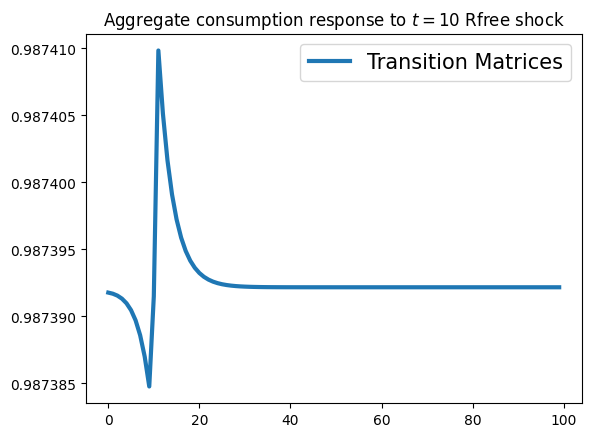

In [10]:
# Plot the simulated consumption response
plt.plot(
    AggC,
    label = "Transition Matrices",
    linewidth = 3.0,
) 
plt.legend(prop={"size": 15})
plt.title("Aggregate consumption response to $t = 10$ Rfree shock")
plt.show()

### Path of Aggregate Assets given an anticipated interest rate shock at $t=10$


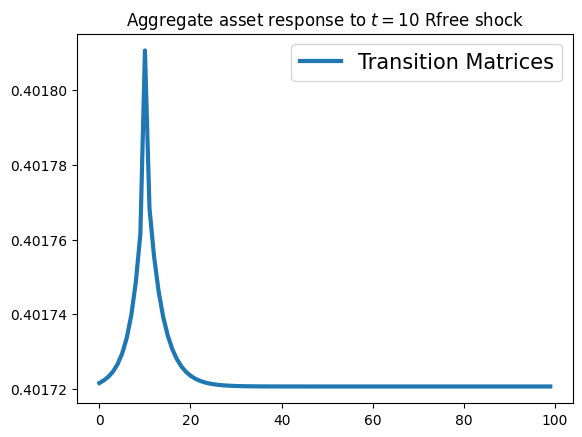

In [11]:
# Plot the simulated asset response
plt.plot(
    AggA,
    label = "Transition Matrices",
    linewidth = 3.0,
) 
plt.legend(prop={"size": 15})
plt.title("Aggregate asset response to $t = 10$ Rfree shock")
plt.show()

## Jacobians

We now move onto computing consumption and asset Jacobians for shocks to Rfree and transitory income distribution's atoms.

To compute a Jacobian, we:
- Declare a finite horizon agent, and compute its response to an anticipated shock in period $T - 1$
- Declare a second finite horizon agent, and compute its response to an unanticipated shock in period 0
- Feed these results to the Auclert et al. Fake News Algorithm

In this cell we're declaring a function that compiles the Jacobian given steady state and finite horizon transition matrices and policies. 

In [12]:
# Declare function that compiles Jacobian given infinite horizon steady state and finite horizon MIT shock 
# solutions and simulation results

def compile_JAC(a_ss, c_ss, a_t, c_t, tranmat_ss, tranmat_t, D_ss, C_ss, A_ss, params, Zeroth_col_agent):

    T = params['T_cycle']

    # Expectation vectors
    exp_vecs_a_e = []
    exp_vec_a_e = a_ss
    
    exp_vecs_c_e = []
    exp_vec_c_e = c_ss
    
    for i in range(T):
        
        exp_vecs_a_e.append(exp_vec_a_e)
        exp_vec_a_e = np.dot(tranmat_ss.T, exp_vec_a_e)
        
        exp_vecs_c_e.append(exp_vec_c_e)
        exp_vec_c_e = np.dot(tranmat_ss.T, exp_vec_c_e)
    
    exp_vecs_a_e = np.array(exp_vecs_a_e)
    exp_vecs_c_e = np.array(exp_vecs_c_e)

    da0_s = []
    dc0_s = []

    for i in range(T):
        da0_s.append(a_t[T - i] - a_ss)
        dc0_s.append(c_t[T - i] - c_ss)
    
        
    da0_s = np.array(da0_s)
    dc0_s = np.array(dc0_s)

    dA0_s = []
    dC0_s = []

    for i in range(T):
        dA0_s.append(np.dot(da0_s[i], D_ss))
        dC0_s.append(np.dot(dc0_s[i], D_ss))
    
    dA0_s = np.array(dA0_s)
    A_curl_s = dA0_s/dx
    
    dC0_s = np.array(dC0_s)
    C_curl_s = dC0_s/dx
    
    dlambda0_s = []
    
    for i in range(T):
        dlambda0_s.append(tranmat_t[T - i] - tranmat_ss)
    
    dlambda0_s = np.array(dlambda0_s)
    
    dD0_s = []
    
    for i in range(T):
        dD0_s.append(np.dot(dlambda0_s[i], D_ss))
    
    dD0_s = np.array(dD0_s)
    D_curl_s = dD0_s/dx
    
    Curl_F_A = np.zeros((T , T))
    Curl_F_C = np.zeros((T , T))
    
    # WARNING: SWAPPED THESE LINES TO MAKE DEMO RUN
    # Curl_F_A[0] = A_curl_s
    # Curl_F_C[0] = C_curl_s
    Curl_F_A[0] = A_curl_s.T[0]
    Curl_F_C[0] = C_curl_s.T[0]

    for i in range(T-1):
        for j in range(T):
            Curl_F_A[i + 1][j] = np.dot(exp_vecs_a_e[i], D_curl_s[j])[0]
            Curl_F_C[i + 1][j] = np.dot(exp_vecs_c_e[i], D_curl_s[j])[0]

    J_A = np.zeros((T, T))
    J_C = np.zeros((T, T))

    for t in range(T):
        for s in range(T):
            if (t ==0) or (s==0):
                J_A[t][s] = Curl_F_A[t][s]
                J_C[t][s] = Curl_F_C[t][s]
                
            else:
                J_A[t][s] = J_A[t - 1][s - 1] + Curl_F_A[t][s]
                J_C[t][s] = J_C[t - 1][s - 1] + Curl_F_C[t][s]
     
    # Zeroth Column of the Jacobian
    Zeroth_col_agent.tran_matrix = np.array(Zeroth_col_agent.tran_matrix)
    
    C_t = np.zeros(T)
    A_t = np.zeros(T)
    
    dstn_dot = D_ss
    
    for t in range(T):
        tran_mat_t = Zeroth_col_agent.tran_matrix[t]

        dstn_all = np.dot(tran_mat_t, dstn_dot)

        C = np.dot(c_ss, dstn_all)
        A = np.dot(a_ss, dstn_all)
        
        C_t[t] = C[0]
        A_t[t] = A[0]

        dstn_dot = dstn_all
        
    J_A.T[0] = (A_t - A_ss) / dx
    J_C.T[0] = (C_t - C_ss) / dx

    return J_C, J_A

### Interest Rate Jacobian

We first create a finite horizon agent and give it an Rfree trajectory with a small perturbation in period $T - 1$.

In [13]:
JacobianRFreeAgent = MarkovConsumerType(**params)
JacobianRFreeAgent.cycles = 1
JacobianRFreeAgent.IncShkDstn = [deepcopy(IncShkDstn[1])]

JacobianRFreeAgent.del_from_time_inv(
    "Rfree",
)
JacobianRFreeAgent.add_to_time_vary("Rfree")

JacobianRFreeAgent.IncShkDstn = params["T_cycle"] * [JacobianRFreeAgent.IncShkDstn[0]]
JacobianRFreeAgent.solution_terminal = deepcopy(agentSS.solution[0])
JacobianRFreeAgent.track_vars = ["cNrm", "pLvl", "aNrm"]

JacobianRFreeAgent.Rfree = (params["T_cycle"] - 1) * [agentSS.Rfree] + [agentSS.Rfree + dx]
JacobianRFreeAgent.solution_terminal = deepcopy(agentSS.solution[0])
JacobianRFreeAgent.solve()

JacobianRFreeAgent.neutral_measure = True
JacobianRFreeAgent.harmenberg_income_process()
JacobianRFreeAgent.define_distribution_grid()

JacobianRFreeAgent.calc_transition_matrix() 

Next, we do the same thing but for a period 0 unanticipated shock.

In [14]:
# do a finite horizon simulation with this agent

ZerothColRFreeAgent = MarkovConsumerType(**params)
ZerothColRFreeAgent.cycles = 1
ZerothColRFreeAgent.IncShkDstn = params["T_cycle"] * [deepcopy(IncShkDstn[1])]
ZerothColRFreeAgent.solution_terminal = deepcopy(agentSS.solution[0])
ZerothColRFreeAgent.track_vars = ["cNrm", "pLvl", "aNrm"]
ZerothColRFreeAgent.solve()

ZerothColRFreeAgent.neutral_measure = True
ZerothColRFreeAgent.harmenberg_income_process()
ZerothColRFreeAgent.define_distribution_grid()

ZerothColRFreeAgent.Rfree  = [agentSS.Rfree + dx] + (params["T_cycle"] - 1) * [agentSS.Rfree]

ZerothColRFreeAgent.calc_transition_matrix()

We now process the finite horizon results and package them for the Fake News Algorithm function.

In [15]:
D_ss = agentSS.vec_erg_dstn

n_p = 1
n_m = len(JacobianRFreeAgent.MrkvArray[0])
c_ss = agentSS.cPol_Grid.flatten()
a_ss = agentSS.aPol_Grid.flatten()
c_t_unflat = JacobianRFreeAgent.cPol_Grid
a_t_unflat = JacobianRFreeAgent.aPol_Grid

A_ss = agentSS.A_ss
C_ss = agentSS.C_ss
    
transition_matrices = JacobianRFreeAgent.tran_matrix

c_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4 * n_p)))
a_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4 * n_p)))

for t in range(params["T_cycle"]):
    c_t_flat[t] = c_t_unflat[t].flatten()
    a_t_flat[t] = a_t_unflat[t].flatten()

tranmat_ss = agentSS.tran_matrix
tranmat_t = np.insert(transition_matrices, params["T_cycle"], tranmat_ss, axis = 0)

c_t = np.insert( c_t_flat, params["T_cycle"] , c_ss , axis = 0)
a_t = np.insert( a_t_flat, params["T_cycle"] , a_ss , axis = 0)

In [16]:
CJAC_RFree, AJAC_RFree = compile_JAC(a_ss,
                                      c_ss,
                                      a_t,
                                      c_t,
                                      tranmat_ss,
                                      tranmat_t,
                                      D_ss,
                                      C_ss,
                                      A_ss,
                                      params,
                                      ZerothColRFreeAgent)

Finally, we may observe the Jacobians for a series of different horizons.

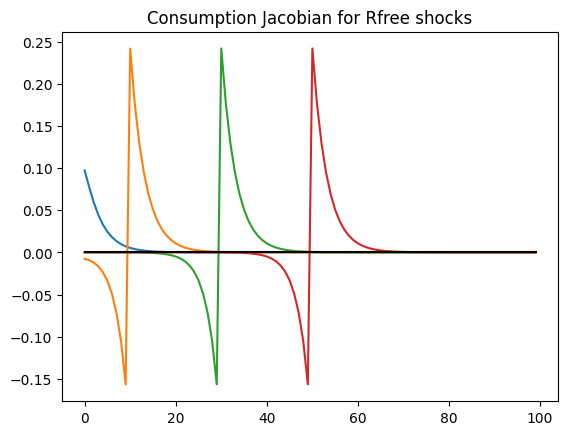

In [17]:
plt.plot(CJAC_RFree.T[0])
plt.plot(CJAC_RFree.T[10])
plt.plot(CJAC_RFree.T[30])
plt.plot(CJAC_RFree.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Consumption Jacobian for Rfree shocks')
plt.show()

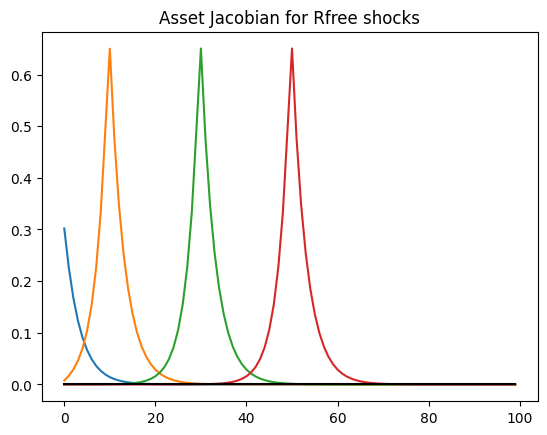

In [18]:
plt.plot(AJAC_RFree.T[0])
plt.plot(AJAC_RFree.T[10])
plt.plot(AJAC_RFree.T[30])
plt.plot(AJAC_RFree.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Asset Jacobian for Rfree shocks')
plt.show()

### Income Jacobian

We now repeat the previous exercise, only now we shock the atoms of the transitory shock distribution.

In [19]:
# declare a temporary agent whose income shock distribution is the perturbed distribution and 
# perform the Harmenburg (2021) normalization

agentSS2 = deepcopy(agent_CG)
agentSS2.IncShkDstn = [deepcopy(IncShkDstn_dx[1])]
agentSS2.neutral_measure = True
agentSS2.harmenberg_income_process()

In [20]:
JacobianIncomeAgent = MarkovConsumerType(**params)
JacobianIncomeAgent.cycles = 1

JacobianIncomeAgent.del_from_time_inv(
    "IncShkDstn",
)
JacobianIncomeAgent.add_to_time_vary("IncShkDstn")

JacobianIncomeAgent.solution_terminal = deepcopy(agentSS.solution[0])

# Before solving, use the non-normalized income shock distributions
JacobianIncomeAgent.IncShkDstn = (params["T_cycle"] - 1) * [deepcopy(IncShkDstn[1])] + [deepcopy(IncShkDstn_dx[1])] + [deepcopy(IncShkDstn[1])]
JacobianIncomeAgent.dist_pGrid = params["T_cycle"] * [np.array([1])]
JacobianIncomeAgent.solution_terminal = deepcopy(agentSS.solution[0])

JacobianIncomeAgent.solve()

# Calculate Transition Matrices
JacobianIncomeAgent.neutral_measure = True

# Now that we are computing transition matrices, we replace the income shock distribution trajectory with Harmenburg (2021) normalized distributions
JacobianIncomeAgent.IncShkDstn = (params["T_cycle"] - 1) * deepcopy(agentSS.IncShkDstn) + \
    deepcopy(agentSS2.IncShkDstn) + deepcopy(IncShkDstn)
JacobianIncomeAgent.define_distribution_grid()
JacobianIncomeAgent.calc_transition_matrix()

In [21]:
ZerothColIncomeAgent = MarkovConsumerType(**params)
ZerothColIncomeAgent.cycles = 1 
ZerothColIncomeAgent.solution_terminal = deepcopy(agentSS.solution[0])
ZerothColIncomeAgent.IncShkDstn = params["T_cycle"] * [deepcopy(IncShkDstn[1])] 
ZerothColIncomeAgent.solve()
ZerothColIncomeAgent.IncShkDstn = deepcopy(agentSS2.IncShkDstn) + (params["T_cycle"]) * deepcopy(agentSS.IncShkDstn)
ZerothColIncomeAgent.neutral_measure = True
ZerothColIncomeAgent.define_distribution_grid()
ZerothColIncomeAgent.calc_transition_matrix()


In [22]:
D_ss = agentSS.vec_erg_dstn

c_ss = agentSS.cPol_Grid.flatten()
a_ss = agentSS.aPol_Grid.flatten()

c_t_unflat = JacobianIncomeAgent.cPol_Grid
a_t_unflat = JacobianIncomeAgent.aPol_Grid

A_ss = agentSS.A_ss
C_ss = agentSS.C_ss
    
transition_matrices = JacobianIncomeAgent.tran_matrix

c_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4)))
a_t_flat = np.zeros((params["T_cycle"], int(params["mCount"] * 4)))

# c_t_flat = np.zeros((params["T_cycle"], params["mCount"], 4))
# a_t_flat = np.zeros((params["T_cycle"], params["mCount"], 4))

for t in range( params["T_cycle"] ):
    c_t_flat[t] = c_t_unflat[t].flatten()
    a_t_flat[t] = a_t_unflat[t].flatten()

tranmat_ss = agentSS.tran_matrix

tranmat_t = np.insert(transition_matrices, params["T_cycle"], tranmat_ss, axis = 0)

c_t = np.insert(c_t_flat, params["T_cycle"] , c_ss , axis = 0)
a_t = np.insert(a_t_flat, params["T_cycle"] , a_ss , axis = 0)

In [23]:
CJAC_Income, AJAC_Income = compile_JAC(a_ss,
                                       c_ss,
                                       a_t,
                                       c_t,
                                       tranmat_ss,
                                       tranmat_t,
                                       D_ss,
                                       C_ss,
                                       A_ss,
                                       params,
                                       ZerothColIncomeAgent)

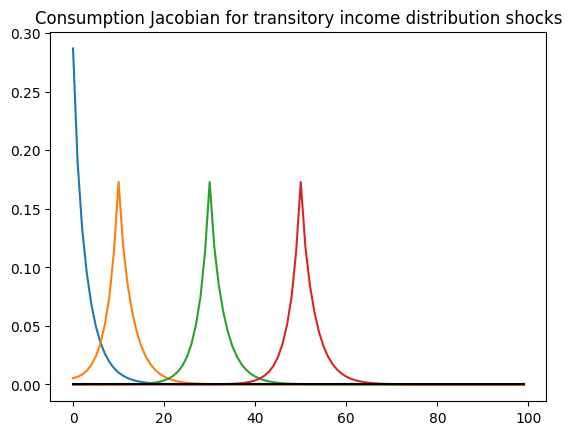

In [24]:
plt.plot(CJAC_Income.T[0])
plt.plot(CJAC_Income.T[10])
plt.plot(CJAC_Income.T[30])
plt.plot(CJAC_Income.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Consumption Jacobian for transitory income distribution shocks')
plt.show()

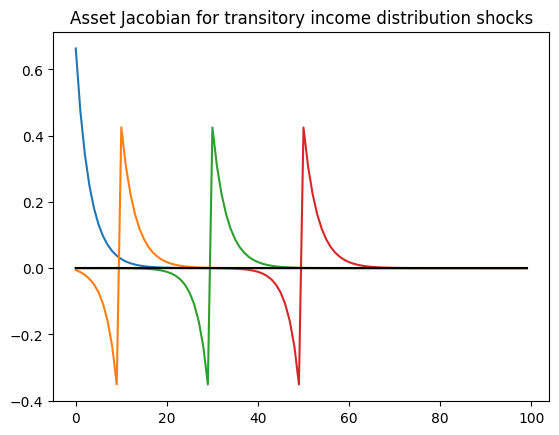

In [25]:
plt.plot(AJAC_Income.T[0])
plt.plot(AJAC_Income.T[10])
plt.plot(AJAC_Income.T[30])
plt.plot(AJAC_Income.T[50])

plt.plot(np.zeros(100) , 'k')
plt.title('Asset Jacobian for transitory income distribution shocks')
plt.show()